### OpenMP




<center>
<font size=7 color='D33513'> Linux Cluster Institute: </font>
</center>
<br>
<center>
<font size=6 color='D33513'>
Introduction to parallel programming techniques
<br>
Part I:  OpenMP

</font>

</center>


<br><br>

<center>
Alexei Kotelnikov, PhD 
    </center>
    <center>
School of Engineering,  
Rutgers University
    </center>
    <center>   
    https://ecs.rutgers.edu
    </center>

<style type="text/css">
    /* 1. Style header/footer <div> so they are positioned as desired. */
    #header-left {
        position: absolute;
        top: 2.5%;
        left: 2.5%;
    }
    #header-right {
        position: absolute;
        top: 2.5%;
        right: 2.5%;
    }
    
    #footer-left {
        position: absolute;
        bottom: 2.5%;
        left: 2.5%;
    }
    
    #footer-right {
        position: absolute;
        bottom: 2.5%;
        right: 2.5%;
    }
    
</style>

<!-- 2. Create hidden header/footer <div> -->
<div id="hidden" style="display:none;">
    <div id="header">
        <div id="header-left"><font size=1 color='D33513'> <i>May 3 2023:   <b>OpenMP</b></i></font> </div>
        <div id="header-right"><img src="LCI_logo.png" width="180"></div>
    </div>
</div>

<script src="https://code.jquery.com/jquery-2.2.4.min.js"></script>
<script type="text/javascript">
    // 3. On Reveal.js ready event, copy header/footer <div> into each `.slide-background` <div>
    var header = $('#header').html();
    if ( window.location.search.match( /print-pdf/gi ) ) {
        Reveal.addEventListener( 'ready', function( event ) {
            $('.slide-background').append(header);
        });
    }
    else {
        $('div.reveal').append(header);
   }
</script>



### Outline of the lecture

- Parallel computing overview
- OpenMP threading model
- OpenMP directives
- Basic techniques in OpenMP:  
         loop parallelization 
         parallel sections
         synchronization constructs
- Code review for the lab exercises with OpenMP  





***

###  Parallel vs Serial computing

- Computational tasks are processed in sequential order, essentially, on one CPU core.   
Doesn't take advantage of the modern multi-core architectures.
- The tasks can be different executable codes, code blocks, loops, subroutines, I/O calls, etc.  

![](IMG/serial.png)





### Parallel vs Serial computing

Computational tasks are processed concurrently on the different CPUs or cores
The platform can be a single multi-core host or a computational cluster of network interconnected hosts or combination of both.  
Special programming methods and software are required, for example, OpenMP or MPI.

![](IMG/parallel.png)





### Parallel computing paradigms: shared memory
Shared memory: all CPUs or cores have access to the same global memory address space.  
Each CPU has its own L1, L2, and L3 cache, as well as CPU cores.  
Most of the main stream commodity based x86 desktops and laptops have CPUs with multiple cores.  
Performance scalability with the number of cores may be low due to CPU-RAM traffic increase, high latency of RAM, and maintaining of the cache coherency.  
Programming approach: multi-threading with POSIX threads (pthreads) and OpenMP.

![](IMG/shared_ram.png)






### Parallel computing paradigms: distributed memory

Distributed memory: the CPUs have access only to their own memory space. Data is exchanged via messages passed over the network.  
The network can be various: Ethernet, Infiniband, OmniPath  

![](IMG/distributed_ram.png)


Programming approach: Message Passing Interface (MPI)





### Parallel computing paradigms: Hardware acceleration

- Hardware acceleration: some tasks are offloaded from CPU onto a multi-core GPU device. Data is transferred over a PCIe bus between the RAM and GPU.  

![](IMG/CPU_GPU_pcie.png)

- Programming approach: CUDA, OpenCL, OpenACC. The latest OpenMP, 5.0, supports offloading to accelerator devices.





### Parallel code performance scalability and theoretical limit

In practice, usually only a part of a code can be efficiently parallelized.   
Amdahl's law imposes a theoretical limit on a parallel code speedup:

Speedup = ${Wall \; clock  \; time \; of \; serial \; execution}\over{Wall \; clock \; time \; of \; parallel \; execution}$ = $1 \over{S + {{P}\over{N}}}$

Where $S$ is the scalar portion of the work,  
$P$ is the parallel portion of the work,  
and $N$ is the number of CPUs or cores.  
By normalization, $S + P = 1$






For example, if only 50% of a code can be parallelized, its theoretical speedup can't exceed the factor of two, according to the Amdahl's law.
As you can see on the graph, it doesn't make much sense utilizing more than 12 CPU cores for running the code since we may be able to reach about 90% of the maximum theoretical speedup on just 12 cores.
When deciding on the maximum number of CPU cores for a production run, do the scalability benchmarks first. 

<img src="IMG/amdahl.png" width="400" height="100" style="float:center">



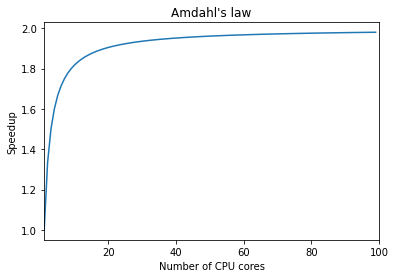

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.xlabel('Number of CPU cores')
    plt.ylabel('Speedup')
    plt.title('Amdahl\'s law')
    plt.xlim(1,100)
    plt.plot(x, y)
# plt.show()
    plt.savefig('IMG/amdahl.png')
    
graph('1/(0.5 + 0.5/x)', range(1, 100))





### Shared memory systems and OpenMP
- All modern desktops and laptops have multi-core CPUs with access to a common memory address space, so considered shared memory architectures.
- You can use OpenMP if you program in C, C++, Fortran 77 or 90.
- OpenMP extension is available in many modern compilers, for example GNU, Intel, PGI, Visual C++.
- No need for a computational cluster.
- Many commercial and open source software packages are already built with OpenMP and can take advantage of multiple CPU cores.
- Can be easily applied to parallelize loops and sections in a serial code.
- Scalability is limited by the number of CPU cores in a system.





### What is OpenMP
- OpenMP is an API environment for shared memory computer architectures.
- It is implemented in the compilers, C/C++, and Fortran, through compiler directives, runtime libraries routines, and environment variables.
- Thread based parallelism: multiple threads concurrently compute tasks in the same code.
- Fork-join thread dynamics: the master thread forks a team of threads in a parallel region, then the threads terminate upon exiting the parallel region.
- Defined data scoping: shared or private to the threads.





### OpenMP workflow schematic

- Shared memory is used by parallel threads.  
- The master process forks threads in the parallel region of the code.  

<img src="IMG/omp_threading1.png" width="500" height="100" style="float:center">





### C/C++ general code structure with OpenMP compiler directives:
<br>

```cpp
int main() {
    int    var1, var2;
    float  var3;

    /* Serial code */ 

    /* Beginning of parallel section. Fork a team of threads. Specify variable scoping */

    #pragma omp parallel  private(var1, var2)  shared(var3)
    {
       /* Parallel section executed by all threads */


       /* All threads join master thread and disband */
    }  
/* Resume serial code */ 
}
```




### OpenMP code compilation and run

Recent gcc and gfortran compilers include OpenMP support.
```bash
gcc -fopenmp -o testcode.x testcode.c
export OMP_NUM_THREADS=4
./testcode.x
```
Usually, `OMP_NUM_THREADS` shouldn't exceed the total number of available cores in a system.  
If `OMP_NUM_THREADS` is undefined, the run will utilize all available cores on the system.





### Running OpenMP apps through SLURM scheduler

A batch submit script:
```yaml
#SBATCH --job-name=OMP_run
#SBATCH --output=slurm.out
#SBATCH --error=slurm.err
#SBATCH --partition=lcilab
#SBATCH --cpus-per-task=4                       

export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK 

./heated_plate.x
```
Submit the script to slurm:
```bash 
sbatch openmp_batch.sh
```

Or run interactively via `srun`:
```bash
srun -n 4 ./heated_plate.x
```




### OpenMP compiler directives – pragma, constructs, clauses
```cpp
#pragma omp construct [clause [clause]…]  
```
For example:  
```cpp
#pragma omp parallel  shared(a,b,c)  private(i)  
#pragma omp sections nowait  
#pragma omp section  
#pragma omp for  
```

The constructs specify what the threads should do, for example:  
Compute concurrently blocks/sections of a code,   _`#pragma omp section`_   
Compute concurrently distributed chunks of loop iterations,  _`#pragma omp for`_  
Thread synchronization,   _`#pragma omp critical`_  

The clauses define the parameters for the constructs, for example: 
Variable scope (private for each thread),  _`private(i)`_  
Variable scope (shared for the threads),  _`shared(a,b,c)`_  
Scheduling directives, _`nowait, schedule`_  
Synchronization related directives,   _`critical, reduction`_  







### The runtime library functions

They set and query parameters for the threads, for example  

`omp_get_num_threads` – returns the number of threads in the running team.

`omp_get_thread_num` – returns the thread number  

There are 57 runtime library functions in the OpenMP in gcc 8.5:  
```bash
egrep 'omp_.*\(' /usr/lib/gcc/x86_64-redhat-linux/8/include/omp.h | wc -l
```

To find out the version of OpenMP in the compiler:
```bash
echo | cpp -fopenmp -dM  |grep -i openmp
```

The output `#define _OPENMP 201511`, mapped to the [specifications](https://www.openmp.org/specifications),
 tells it is v 4.5
 




### Parallel regions
Simple "Hello World" program. Every thread executes all code enclosed in the parallel section. OpenMP library routines are used to obtain thread identifiers and total number of threads.
```cpp
#include <omp.h>
#include <stdio.h>
int main () {
    int nthreads, tid;
    /* Fork a team of threads with each thread having a private tid variable */
    #pragma omp parallel private(tid)
      {
      /* Obtain and print thread id */
      tid = omp_get_thread_num();
      printf("Hello World from thread = %d\n", tid);

      /* Only master thread does this */
      if (tid == 0)
        {
        nthreads = omp_get_num_threads();
        printf("Number of threads = %d\n", nthreads);
        }  /* All threads join master thread and terminate */
      }
}
```





### Parallel loops
An `OMP_NUM_THREADS=4` simple work sharing construct: parallel loops  

```cpp
/* Fork a team of threads with private i , tid  variables */
#pragma omp parallel private(i, tid)
{
      same_work();  
// Compute the for loop iteractions in parallel
#pragma omp for 
  for (i=0; i<=4*N-1; i++) 
  { 
      thread(i);  //should be a thread safe function
  }              //the final results are independent on the order of the loop iteration 
}     
```            
     
![](IMG/pragma_omp_for.png)





### The `for` loop construct

Since the parallel region has been defined, the iterations of the loop must be executed in parallel by the team. 

```cpp
#pragma omp for [clause ...] 
    schedule (type [,chunk]) //how the loop iterations assigned to threads 
    private (list)           //the variable scope private to the threads
    shared (list).            //the variable scope shared to the threads
    reduction (operator: list) //if reduction is applied to the total value
    collapse (n)                //in case of nested loop parallelization
    nowait //if set, the threads do not synchronize at the end of the loop
```

There are other possible clauses in the `for` construct not discussed here.






### The `for` loop schedule clause

Describes how the iterations of the loop are divided among the threads in the team. 
`STATIC`: loop iterations are divided into pieces of size chunk and then statically assigned to the threads.  
`DYNAMIC`:   the chunks, and dynamically scheduled among the threads; when a thread finishes one chunk, it is dynamically assigned another. The default chunk size is 1.  
`GUIDED`:   similar to DYNAMIC except that the block size decreases each time a parcel of work is given to a thread.  
`RUNTIME`:   defined by the environment variable OMP_SCHEDULE  
`AUTO`:   the scheduling decision is delegated to the compiler and/or runtime system.  




### The `for` loop example

The loop iterations computed concurrently.

```cpp

    /* Some initializations */
    for (i=0; i < N; i++) 
      a[i] = b[i] = i * 1.0;
    chunk = CHUNKSIZE;

    #pragma omp parallel shared(a,b,c,chunk) private(i) 
    #pragma omp for schedule(dynamic,chunk) nowait
      for (i=0; i < N; i++)
       {
         c[i] = a[i] + b[i];

         /* Obtain and print thread id and array index number */
         tid = omp_get_thread_num();
         printf("thread = %d, i = %d\n", tid, i);

       }  /* end of parallel section */
```




### Nested loops

By default only the outer loop is parallelized:

```cpp
#pragma omp parallel for
    for (int i=0;i<N;i++)
    { 
      for (int j=0;j<M;j++)
      {
       /* do task(i,j) */
      }
    }
```

To parallelize both the loops:
```cpp
#pragma omp parallel for collapse(2) 
    for (int i=0;i<N;i++)
    { 
      for (int j=0;j<M;j++)
      {
       /* do task(i,j) */
      }
}
```




### Parallel sections example
Independent SECTION directives are nested within a SECTIONS directive. Each SECTION is executed once by a thread in the team. Different sections may be executed by different threads. It is possible that for a thread to execute more than one section if it is quick enough and the implementation permits such.

```cpp
   #pragma omp parallel shared(a,b,c,d) private(i) {
     #pragma omp sections nowait {
       #pragma omp section {
        for (i=0; i < N; i++)
           c[i] = a[i] + b[i];
           /* Obtain and print thread id and array index number */
           tid = omp_get_thread_num();
           printf("thread = %d, i = %d\n", tid, i);
        }
        #pragma omp section {
        for (i=0; i < N; i++)
          d[i] = a[i] * b[i];
          /* Obtain and print thread id and array index number */
          tid = omp_get_thread_num();
          printf("thread = %d, i = %d\n", tid, i); }
       }  /* end of sections */
      }  /* end of parallel sections */
```





### When things may become messy

Several threads are updating the same variable.

```cpp 
#pragma omp parallel for shared (sum) private (i) 
    for ( int i=0; i < 1000000; i++) {
           sum = sum + a[i];
        }
    printf("sum=%lf\n",sum);
```

The threads overwrite the sum variable for each other, running into the “race condition”.  
The problem can be solved by using critical locks and critical sections, when only one thread at a time updates the sum.





### Synchronization construct `critical`
<br>

```cpp
#pragma omp parallel for shared (sum) private (i) 
        for ( int i=0; i < 1000000; i++) {
         #pragma omp critical
           sum = sum + a[i];
        }
      printf("sum=%lf\n",sum);
```
The `critical` section specifies a region of a code that must be executed by only one thread at a time. 




### Reduction clause

Scalar product of two vectors, $\vec{A}$ and $\vec{B}$:  


result = $(\vec{A} \cdot \vec{B})$ = $A_0 \cdot B_0 + A_1 \cdot B_1 + … + A_{n-1} \cdot B_{n-1} $  

Have each thread to compute partial sums, `result`,  on a chunk of data.

```cpp
#pragma omp parallel for      \
      default(shared) private(i)  \
      schedule(static,chunk)      \
      reduction(+:result)

      for (i=0; i < n; i++)
        result = result + (a[i] * b[i]);    
```
A private copy for variable `result` is created for each thread. At the end of the reduction, the reduction variable is written in the global shared variable.





### Constructs for single thread execution in parallel region

Only by the _master_ thread:
```cpp
#pragma omp master
 {
 printf( "iteration %d, toobig=%d\n", c, toobig );
 }
```
Only by any _single_ thread:
```cpp
#pragma omp single
{
printf ("Outer: num_thds=%d\n", omp_get_num_threads());
}
```






### The `atomic` construct


The omp atomic construct allows access of a specific memory location atomically,
 avoiding race conditions. Here it simultaneous updates of an element of x
by multiple threads. 
```cpp    
#pragma omp parallel for shared(x, y, index, n)
   for (i=0; i<n; i++) {
   #pragma omp atomic update
     x[index[i]] += work1(i);
     y[i] += work2(i);
}
```
Note that the atomic directive applies only to the statement immediately following it.
As a result, elements of y are not updated atomically in this example.





### Synchronization construct `barrier`

```cpp
#pragma omp barrier 
```

The omp barrier directive identifies a synchronization point at which threads in a parallel region will wait until all other threads in that section reach the same point. Statement execution past the omp barrier point then continues in parallel.





### OpenMP lab exercise review

*Heated 2D Plate problem*

The physical 2D region, and the boundary conditions, are suggested by this diagram.
Need to find a steady state temperature distribution, W(x,y)

                   W = 0
             +------------------+
             |                  |
    W = 100  |                  | W = 100
             |                  |
             +------------------+
                   W = 100
                   





*Numerical discretization: M x N nodes*

                  I = 0
          [0][0]-------------[0][N-1]
             |                  |
      J = 0  |                  |  J = N-1
             |                  |
        [M-1][0]-----------[M-1][N-1]
                  I = M-1

*Computational approach - convergence to the steady state by Jacobi iterations:*
```cpp
while ( epsilon <= diff ) {
    w[i][j] = ( u[i-1][j] + u[i+1][j] + u[i][j-1] + u[i][j+1] ) / 4.0;
    diff = max|w[i][j] - u[i][j]|;
    u[i][j] = w[i][j];
    iterate++;  }
```




### OpenMP approach through loop parallelization
The temperature, `w`, update via iteration:
```cpp
# pragma omp for
      for ( i = 1; i < M - 1; i++ )
      {
        for ( j = 1; j < N - 1; j++ )
        {
          w[i][j] = ( u[i-1][j] + u[i+1][j] + u[i][j-1] + u[i][j+1] ) / 4.0;
        }
      }
    }
```




Iteration convergence factor estimate, `diff`:
```cpp  
# pragma omp parallel shared ( diff, u, w ) private ( i, j, my_diff )
    { my_diff = 0.0;
# pragma omp for
      for ( i = 1; i < M - 1; i++ )
      { for ( j = 1; j < N - 1; j++ )
        {
          if ( my_diff < fabs ( w[i][j] - u[i][j] ) )
          {
            my_diff = fabs ( w[i][j] - u[i][j] );
          }
        }
      }
# pragma omp critical
      { if ( diff < my_diff )
        {
          diff = my_diff;
        }
      }
    }
```




### CPU core number and performance  (lab exercise)

Compile the source code with OpenMP:
```bash
gcc -fopenmp -o heated_plate.x heated_plate_openmp.c -lm
```
Run the compiled executable, `heated_plate.x`, with one thread:
```bash
export OMP_NUM_THREADS=1
./heated_plate.x > heated_plate_local_gcc_output.txt
```
Run it with 2 threads:
```bash
export OMP_NUM_THREADS=2
./heated_plate.x >> heated_plate_local_gcc_output.txt
```
The output results in the two runs above have been written in file `heated_plate_local_gcc_output.txt`
Compare the run time (Wallclock time) in the above cases:
```bash
grep Wallclock heated_plate_local_gcc_output.txt
```



## References


[LLNL Introduction to Parallel Computing](https://hpc.llnl.gov/documentation/tutorials/introduction-parallel-computing-tutorial)  

[LLNL OpenMP tutorial](https://hpc-tutorials.llnl.gov/openmp/)  

[OpenMP 4.0 Examples](https://www.openmp.org/wp-content/uploads/OpenMP4.0.0_Examples.pdf)



## Questions and discussion: